In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
import matplotlib.pyplot as plt
from pylib.utils.functions_for_classification import mixed_2d_2cls, plot_scatter

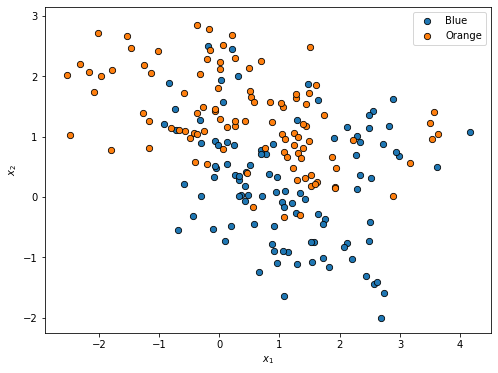

In [3]:
X_train, X_test, y_train, y_test = mixed_2d_2cls()
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train)
plt.show()

## 梯度提升分类

In [4]:
from pylib.utils.functions_for_classification import plot_decision_boundary
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from matplotlib.colors import ListedColormap
import numpy as np

In [5]:
class GradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    """
    梯度提升分类
    
    参数：
    -----
    n_estimators：基本学习器的数量
    learning_rate：学习率，也可看做收缩参数
    max_depth：限制树的最大深度
    min_sample_leaf：叶子节点所允许包含的最小样本数量
    random_state：随机状态。若指定为整数，则能做出可重复结果
    
    属性：
    y0：函数参数的初始值，为目标变量的平均值
    loss_history：记录历史损失值
    """
    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, min_sample_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.random_state = random_state
        
    def __deviance_neg_gradient(self, y, y_pred):
        margin = np.multiply(y, y_pred)
        return (y * np.exp(-margin)) / (1 + np.exp(-margin))
    
    def __deviance(self, y, y_pred):
        y = np.where(y >= 1, 1, 0)
        y_pred = np.where(y_pred >= 0, 1, 0)
        epsilon = 1e-8
        return -np.sum(np.multiply(y, np.log(y_pred + epsilon)) + \
                        np.multiply(1 - y, np.log(1 - y_pred + epsilon))) / len(y)
        
    def fit(self, X, y):
        y = np.where(y >= 1, 1, -1)
        self.base_learners = []
        self.y0 = np.mean(y)
        yim = np.repeat(self.y0, len(X))  
        self.loss_history = []
        for m in range(self.n_estimators):
            base_learner = DecisionTreeRegressor(max_depth=self.max_depth,
                                                 min_samples_leaf=self.min_sample_leaf,
                                                 random_state=self.random_state)
            neg_grad = self.__deviance_neg_gradient(y, yim)
            base_learner.fit(X, neg_grad)
            yim += self.learning_rate * base_learner.predict(X)  # 更新函数参数
            self.base_learners.append(base_learner)
            loss = self.__deviance(y, yim)
            self.loss_history.append(loss)
            
        return self
    
    def predict(self, X):
        y_pred = np.repeat(self.y0, len(X))
        for learner in self.base_learners:
            y_pred += self.learning_rate * learner.predict(X)
        y_pred = np.where(y_pred > self.y0, 1, 0)
        return y_pred

In [6]:
gbdt = GradientBoostingClassifier(random_state=42)
gbdt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.1, max_depth=3, min_sample_leaf=1,
                           n_estimators=100, random_state=42)

In [7]:
train_err = 1 - gbdt.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.100


In [8]:
test_err = 1 - gbdt.score(X_test, y_test)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.238


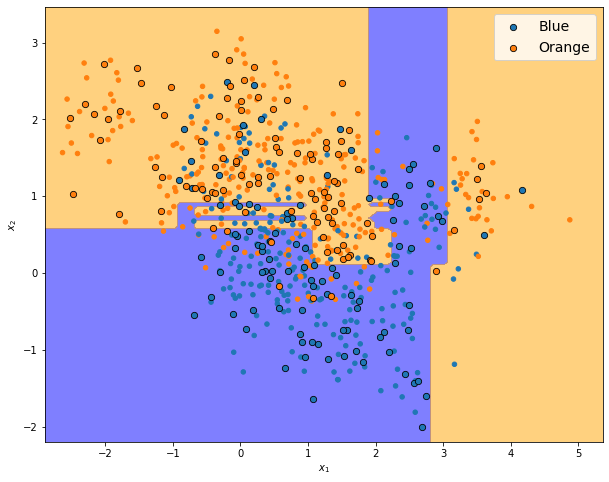

In [9]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, gbdt)
plt.show()

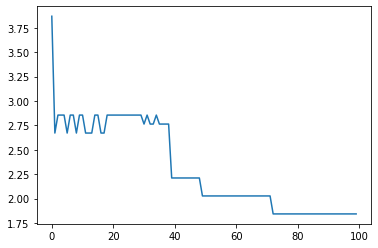

In [10]:
# 绘制历史损失值
loss_history = gbdt.loss_history
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 查看一系列学习器的决策边界

In [11]:
learners = gbdt.base_learners

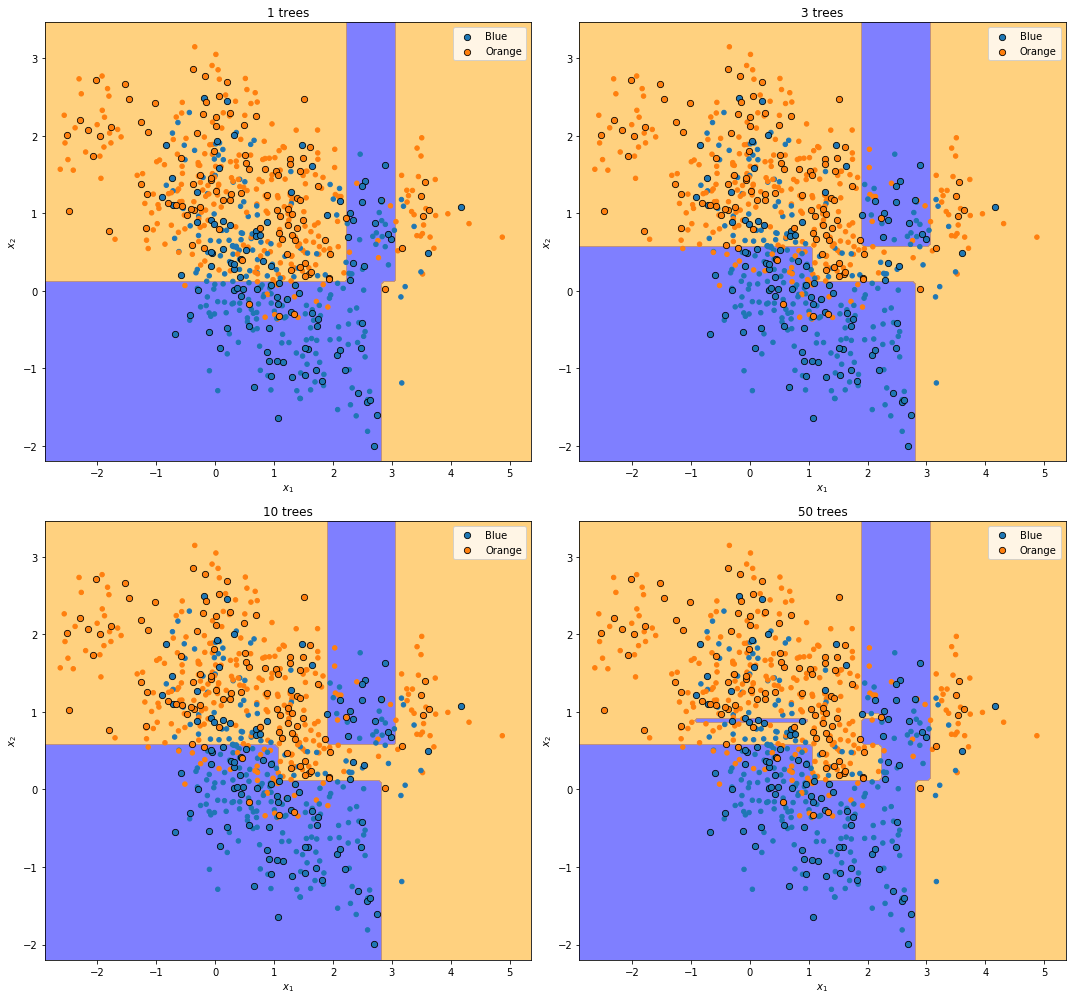

In [15]:
colors = ['blue', 'orange']
cmap = ListedColormap(colors)
h = 100
X = np.r_[X_train, X_test]
x1n_min = 1.1 * X[:, 0].min()
x1n_max = 1.1 * X[:, 0].max()
x2n_min = 1.1 * X[:, 1].min()
x2n_max = 1.1 * X[:, 1].max()
x1n = np.linspace(x1n_min, x1n_max, h)
x2n = np.linspace(x2n_min, x2n_max, h)
xx1n, xx2n = np.meshgrid(x1n, x2n)
Xn = np.c_[xx1n.ravel(), xx2n.ravel()]

num = [1, 3, 10, 50]
plt.figure(figsize=(15, 14))
for i, j in enumerate(num):
    yy = gbdt.y0
    for learner in learners[:j]:
        yi_pred = np.array([learner.predict(xx.reshape(1, -1)) for xx in Xn]).reshape(xx1n.shape)
        yy += gbdt.learning_rate * yi_pred
    yy = np.where(yy > 0, 1, 0)
    plt.subplot(int("22{}".format(i+1)))
    plot_scatter(X_train, y_train, X_test, y_test)
    plt.contourf(xx1n, xx2n, yy, levels=1, cmap=cmap, alpha=0.5, zorder=-1)
    plt.title("{} trees".format(j))
plt.tight_layout()
plt.show()